In [1]:
from IPython.display import Image


In [2]:
%%html
<iframe src="https://xgboost.readthedocs.io/en/latest/tutorials/model.html" width="1100" height="1000"></iframe>


# Data 

https://www.kaggle.com/c/the-winton-stock-market-challenge/data

Updated 2015-12-21: Winton have added new data into the test set. If you downloaded the test set before 2015-12-21 please re-download the data set and submit predictions on this instead. 

In this competition the challenge is to predict the return of a stock, given the history of the past few days. 

We provide 5-day windows of time, days D-2, D-1, D, D+1, and D+2. You are given returns in days D-2, D-1, and part of day D, and you are asked to predict the returns in the rest of day D, and in days D+1 and D+2.

During day D, there is intraday return data, which are the returns at different points in the day. We provide 180 minutes of data, from t=1 to t=180. In the training set you are given the full 180 minutes, in the test set just the first 120 minutes are provided.

For each 5-day window, we also provide 25 features, Feature_1 to Feature_25. These may or may not be useful in your prediction.

### Note
***Each row in the dataset is an arbitrary stock at an arbitrary 5 day time window***.



# File descriptions
***train.csv*** - the training set, including the columns of:
* Feature_1 - Feature_25
* Ret_MinusTwo, Ret_MinusOne
* Ret_2 - Ret_120
* Ret_121 - Ret_180: ***target variables***
* Ret_PlusOne, Ret_PlusTwo: ***target variables***
* Weight_Intraday, Weight_Daily

***test.csv*** - the test set, including the columns of:

* Feature_1 - Feature_25
* Ret_MinusTwo, Ret_MinusOne
* Ret_2 - Ret_120

***sample_submission.csv*** - a sample submission file in the correct format


Data fields
Feature_1 to Feature_25: different features relevant to prediction
Ret_MinusTwo:  this is the return from the close of trading on day D-2 to the close of trading on day D-1 (i.e. 1 day)
Ret_MinusOne: this is the return from the close of trading on day D-1 to the point at which the intraday returns start on day D (approximately 1/2 day)
Ret_2 to Ret_120: these are returns over approximately one minute on day D. Ret_2 is the return between t=1 and t=2. 
Ret_121 to Ret_180: intraday returns over approximately one minute on day D. These are the target variables you need to predict as {id}_{1-60}. 
Ret_PlusOne: this is the return from the time Ret_180 is measured on day D to the close of trading on day D+1. (approximately 1
day). This is a target variable you need to predict as {id}_61. 
Ret_PlusTwo: this is the return from the close of trading on day D+1 to the close of trading on day D+2 (i.e. 1 day) This is a target variable you need to predict as {id}_62. 

**Weight_Intraday**: weight used to evaluate intraday return predictions Ret 121 to 180

**Weight_Daily**: weight used to evaluate daily return predictions (Ret_PlusOne and Ret_PlusTwo).

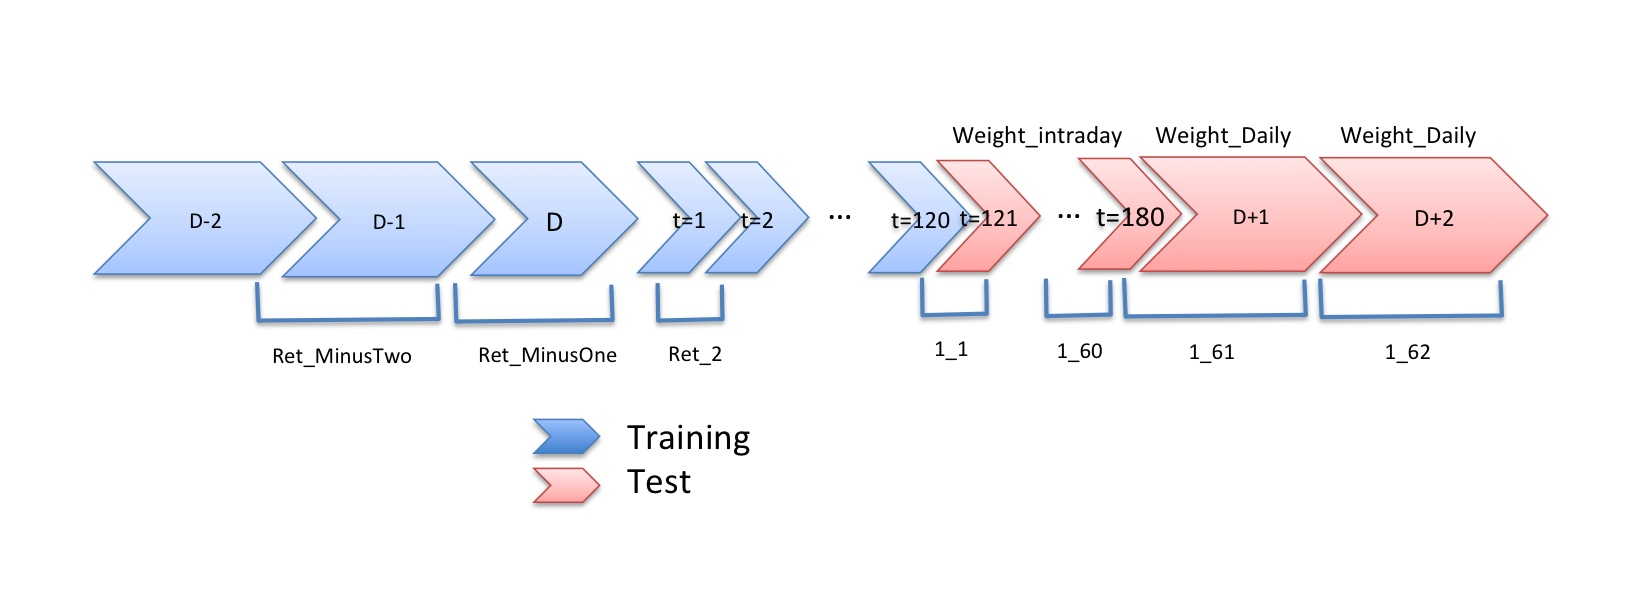

In [3]:
Image(filename="Presentation1.jpg")

In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb


ModuleNotFoundError: No module named 'xgboost'

In [ ]:
PROJECT_ROOT_DIR = os.path.join(os.path.dirname('__file__'), '.')
PROJECT_DATA_DIR = os.path.join(PROJECT_ROOT_DIR, 'data')

In [ ]:
train = pd.read_csv(os.path.join(PROJECT_DATA_DIR, 'train_winton.csv')).drop('Id', axis=1)
test = pd.read_csv(os.path.join(PROJECT_DATA_DIR, 'test_2_winton.csv')).drop('Id', axis=1)

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
no_col = len(train.columns)
print('train.columns:')
print(train.columns)

print('test.columns:')
print(test.columns)
print(train.info())

print('.' * 50)
print('train:')
print(train.head())
print('.' * 50)
print('test:')
print(test.head())


In [ ]:
#for col in train.columns:
#(100 * train.isnull().sum()/len(train)).round(2) 

In [ ]:
train.T.head(no_col)

In [ ]:
train.info()

In [ ]:
train.shape

In [ ]:
train.shape, test.shape

In [ ]:
def get_percentage_missing(series):
    return round(series.isnull().sum()/len(series), 2)

In [ ]:
def delete_na(df, thresh=0.4):
    for col in df.columns.tolist():
        if get_percentage_missing(df[col]) > thresh:
            print(get_percentage_missing(df[col]))
            print('Deleting Column {}'.format(col))
            df.drop(col, axis=1, inplace=True)
    return df

In [ ]:
xtrain = train.iloc[:, :146] # pick the first 147 columns as input x
#print(xtrain.shape)
#print(xtrain.head())
ytrain = train.iloc[:, 146:] # pick from column 147 to the end for output y
#print(ytrain.head())
xtrain.shape, ytrain.shape

In [ ]:
#xtrain = xtrain[xtrain.columns[xtrain.isnull().any()].tolist()]

In [ ]:
xtrain.drop(['Feature_1', 'Feature_10'], axis=1, inplace=True)
test.drop(['Feature_1', 'Feature_10'], axis=1, inplace=True)

In [ ]:
xtrain.shape, test.shape

# First version, do not use features 1-25

In [ ]:
# the column index might need to be changed because we deleted column id
#xtrain = xtrain.iloc[:, 25:] # note xtrain.iloc[...]

In [ ]:
print(xtrain.shape)

xtrain.head()

In [ ]:
test.head()

In [ ]:
cols = 0
for col in xtrain.columns:
    if col.startswith('Feature'):
        cols += 1
print(cols)

In [ ]:
xtrain = xtrain.iloc[:, cols:]
#xtest = test.iloc[:, cols:]
#print(xtrain.shape, xtest.shape)
xtrain.head()

In [ ]:
ytrain.head()

In [ ]:
#numnames = xtrain.select_dtypes(exclude=object).columns.tolist()

In [ ]:
#numnames[:5]

In [ ]:
print(xtrain.iloc[:1, 2:].head())
plt.figure(figsize=(10, 6))
plt.title('Minute returns for first stock')
plt.plot(xtrain.iloc[:1, 2:].values.flatten())
plt.xlabel('time in minutes')
plt.ylabel('returns in (minutes)');

### plot minute returns for first 5 rows = 5 stocks

In [ ]:
def plot_stocks(xtrain, row=1, colstart=2, endcol=None):
    plt.figure(figsize=(10, 6))
    plt.title('Minute stock returns')
    plt.plot(xtrain.iloc[:row, colstart:endcol].values.flatten())
    plt.xlabel('time in minutes')
    plt.ylabel('returns in (minutes)');

In [ ]:
#def run_plot(xtrain, start=1, end=10):
#    for i in range(start, end):
#        plot_stocks(xtrain, row=i)

In [ ]:
print(xtrain.iloc[:1, 2:].head())
for i in range(1, 5):
    plot_stocks(xtrain, row=i)

In [ ]:
print(xtrain.iloc[:1, 2:].head())
for i in range(1, 3):
    plot_stocks(xtrain, row=i, colstart=None)

## outputs

In [ ]:
#print(ytrain.head())
print('.' * 50)
print(ytrain.shape)
print(ytrain.iloc[:1, :60].head())
for i in range(1, 3):
    plot_stocks(ytrain, row=i, endcol=60)

In [ ]:
#print(ytrain.head())
print('.' * 50)
print(ytrain.shape)
print(ytrain.iloc[:1, :62].head())
for i in range(1, 3):
    plot_stocks(ytrain, row=i, endcol=62)

In [ ]:
#print(ytrain.columns)
y1 = ytrain['Ret_PlusOne'] # D + 1 returns
y2 = ytrain['Ret_PlusTwo'] # D + 2 returns

print(y1.shape, y2.shape)
print()
print(y1.head(2))
print()
print(y2.head(2))

# Machine learning

In [ ]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor # used for transforming the target variable
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from dask.distributed import Client
from scipy.stats import uniform


np.random.seed(100)

# Predict: D + 1 Returns

In [ ]:
xtrain, xtest, ytrain1, ytest1 = train_test_split(xtrain, y1, shuffle=True)

In [ ]:
xtrain.shape, xtest.shape, ytrain1.shape, ytest1.shape

In [ ]:
imp = SimpleImputer(strategy='median')
xtrain = imp.fit_transform(xtrain)
xtest = imp.transform(xtest)

scaler = QuantileTransformer(output_distribution='normal')
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

# Scores and hyperparameter optimization
* Randomized search, See the theory on how it is done with deep learning
http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf

* with reinforcement learning
https://arxiv.org/pdf/1906.11527.pdf

* R2 (0, 1), where 1 is good fit
* Explainde variance score (0, 1) where 1 is good fit

In [ ]:
transformer = QuantileTransformer(output_distribution='normal')
# we might need to do grid or random search
regressor = RandomForestRegressor() #Ridge(alpha=0.1)


param_dist = {"max_depth": sp_randint(5, 10),
              "max_features": sp_randint(2, 8),
              "min_samples_split": sp_randint(5, 10),
              "bootstrap": [True, False],
              "criterion": ["mae", "mse"], 
              "n_estimators": sp_randint(60, 70)}

#reg.fit(xtrain, ytrain1)


xgb_reg = xgb.XGBRegressor(objective='reg:squarederror')

rxgb_dict = {"subsample": uniform(0.0, 0.99),
             "num_round": sp_randint(10, 700),
             "min_child_weight": uniform(1.0, 5.0),
             "max_depth": sp_randint(3, 9),
             "learning_rate": uniform(0.05, 0.08),
             "colsample_bytree": uniform(0.2, 0.6)}

# use the train examples only
# for hyper parameter optimization
train_samples = 5000
test_samples = 6000
xtr = xtrain[:train_samples, :]
ytr = ytrain1[:train_samples]

xts = xtrain[train_samples:test_samples, :]
yts = ytrain1[train_samples:test_samples]

param_dicts = [param_dist, rxgb_dict]
models = [regressor, xgb_reg]


n_iter_search = 10
for regressor, param_dist in zip(models, param_dicts):
    reg = RandomizedSearchCV(regressor, 
                             param_distributions=param_dist, 
                             n_iter=n_iter_search, 
                             cv=3, 
                             iid=False, 
                             verbose=10, 
                             n_jobs=-1)

    reg.fit(xtr, ytr)
    print('Done with training.')
    pred_train = reg.predict(xtr)
    pred_test = reg.predict(xts)

    sctest = r2_score(yts, pred_test)
    sctrain = r2_score(ytr, pred_train)

    mse_train = mean_squared_error(ytr, pred_train)
    mse_test = mean_squared_error(yts, pred_test)

    ex_variance_train = explained_variance_score(ytr, pred_train)
    ex_variance_test = explained_variance_score(yts, pred_test)

    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)

    print('R2 score train score: {} score test set: {}'.format(sctrain, sctest))
    print('Mean-squared error train set: {} test set: {}'.format(mse_train, mse_test))
    print('Explained variance train set: {} test set: {}'.format(ex_variance_train, ex_variance_test))
    print('Root means squared error train set {} test set: {}'.format(rmse_train, rmse_test))
    print('Best Score:', reg.best_score_)
    print('Best params:', reg.best_params_)